In [ ]:
##### Lets initialize some tensors in Python/Numpy
import numpy as np
import sys
import numpy as np
sys.path.append("../")
import tensornetworks as tn
from scipy.linalg import eigh, svd, sqrtm

In [ ]:
def create_mps(D, d, N):
    MPS=[]
    MPS_Zalo = []
    step = np.random.rand(D,d)+1j*np.random.rand(D,d)
    MPS_Zalo.append(step.transpose(1,0).reshape((d, 1, D)))
    MPS.append(step)
    for _ in range(1,N-1):
        step = np.random.rand(D,D,d)+1j*np.random.rand(D,D,d)
        MPS.append(step)
        MPS_Zalo.append(step.transpose(2, 0, 1))
    step = np.random.rand(D,d)+1j*np.random.rand(D,d)
    MPS.append(step)
    MPS_Zalo.append(step.transpose(1,0).reshape((d, D, 1)))
    return MPS, MPS_Zalo

In [ ]:
d = 2
D = 4
N = 4
MPS, MPS_Zalo = create_mps(D, d, N)

## Isometries using Direct Orhtogonalization

In [ ]:
i = 1
tensor = MPS_Zalo[i]
tensor.shape

Computing left density matrix

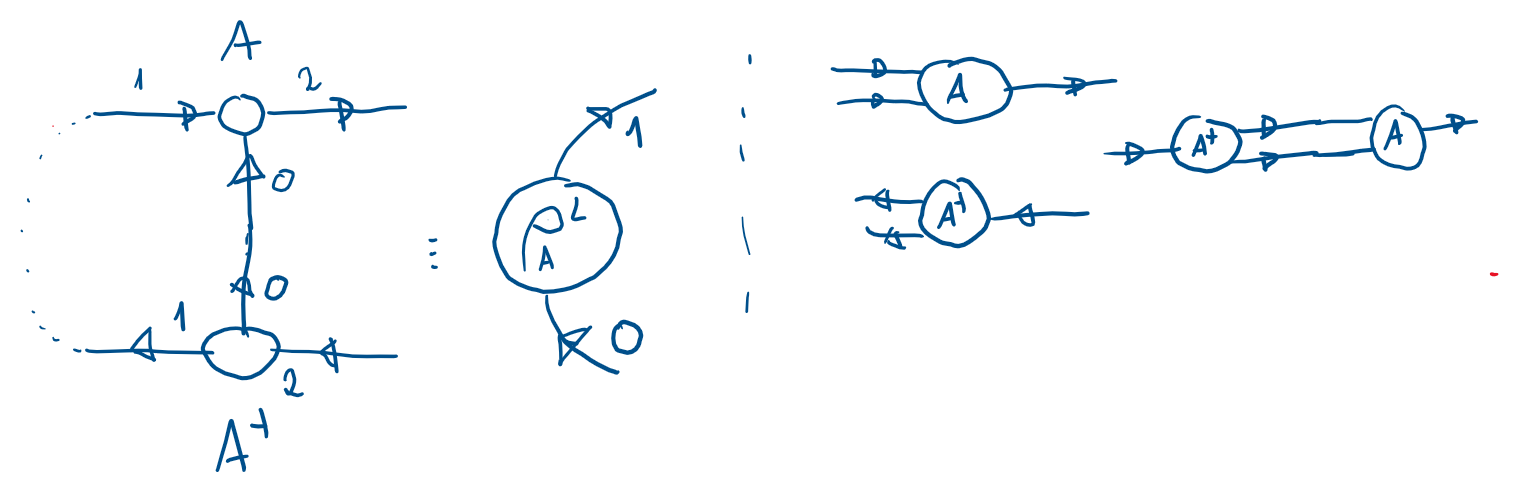

In [ ]:
# Computes left density matrix
left_rho = tn.contract_indices(tensor.conj(), tensor, [0, 1],[0, 1])
left_rho.shape

In [ ]:
m = tensor.reshape(D*d, D)
np.isclose(m.conj().T @ m, left_rho).all()

Computing Right Density Matrix

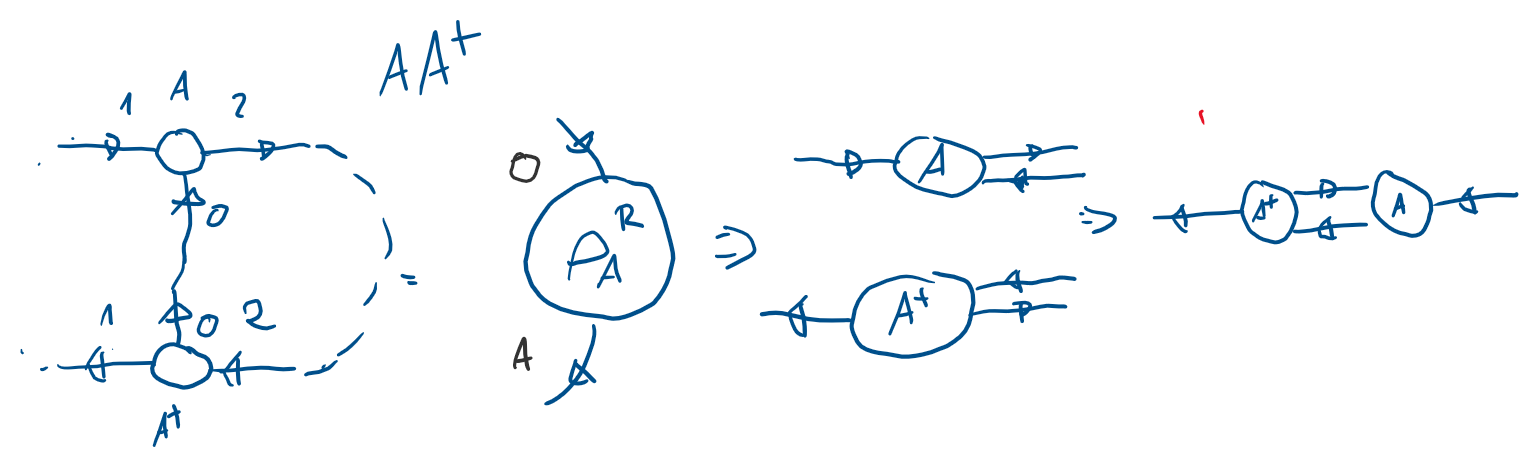

In [ ]:
# Computes left density matrix
right_rho = tn.contract_indices(tensor, tensor.conj(), [0, 2],[0, 2])
right_rho.shape

In [ ]:
m = tensor.transpose(1, 0, 2).reshape(D, D*d)
np.isclose(m @ m.conj().T, right_rho).all()

In [ ]:
# Matrix Square Root of left rho
sqrt_right = sqrtm(abs(left_rho))
np.isclose(sqrt_right @ sqrt_right, abs(left_rho)).all()

In [ ]:
# Matrix Square Root of Right rho
sqrt_left = sqrtm(right_rho)
np.isclose(sqrt_left @ sqrt_left, right_rho).all()

Building left isometry using direct orthogonalization

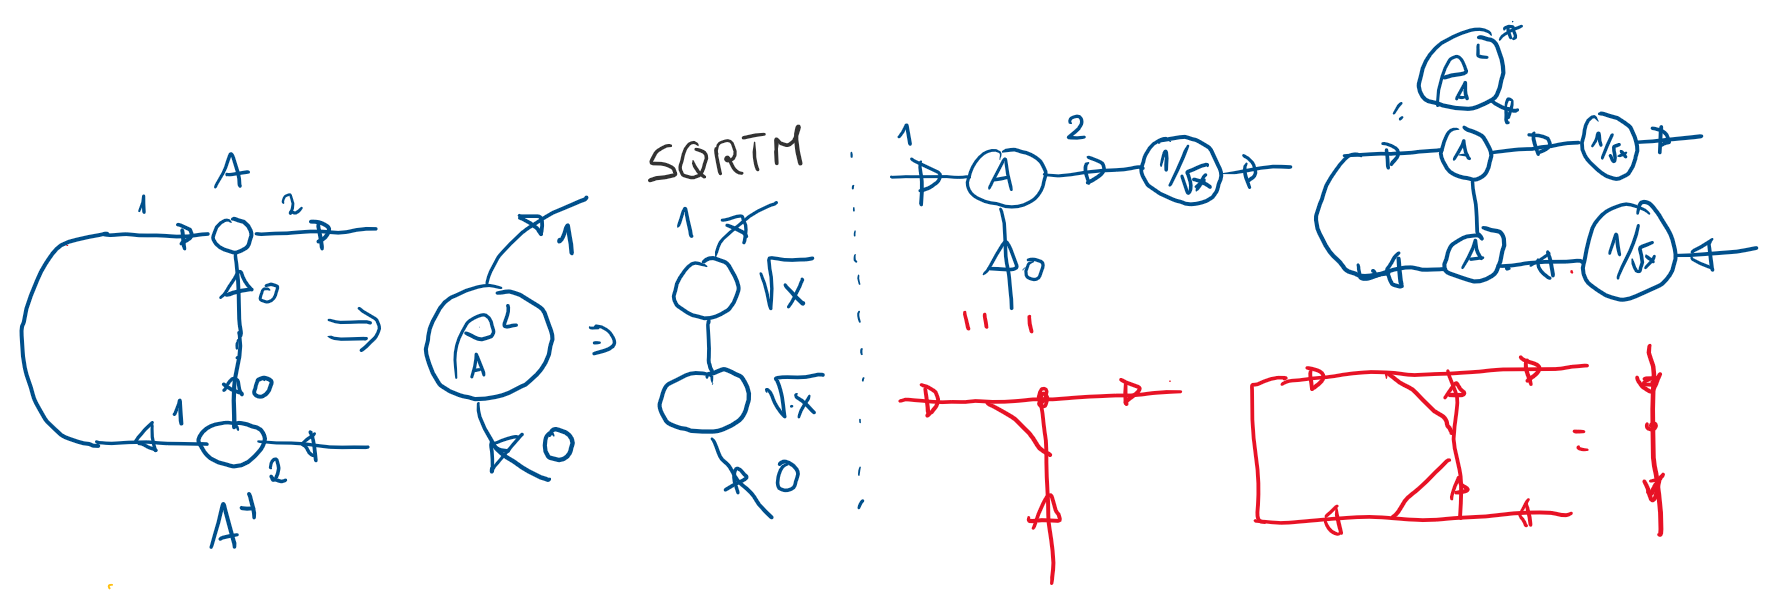

In [ ]:
from scipy.linalg import eigh, svd, sqrtm, inv

def left_isometry_do(tensor):
    """
    Computes left isometry using direct orthogonalization
    """
    # Computes left density matrix
    left_rho = tn.contract_indices(tensor.conj(), tensor, [0, 1],[0, 1])
    sqrt_right = sqrtm(left_rho)
    left_isometry = tn.contract_indices(tensor, inv(sqrt_right), [2], [0])
    return left_isometry, sqrt_right

In [ ]:
# Left Isometry Test
left_isometry, sqrt_right = left_isometry_do(tensor)
np.isclose(
    tn.contract_indices(left_isometry.conj(), left_isometry, [0, 1], [0, 1]),
    np.eye(D)
).all()

Building right isometry using direct orthogonalization

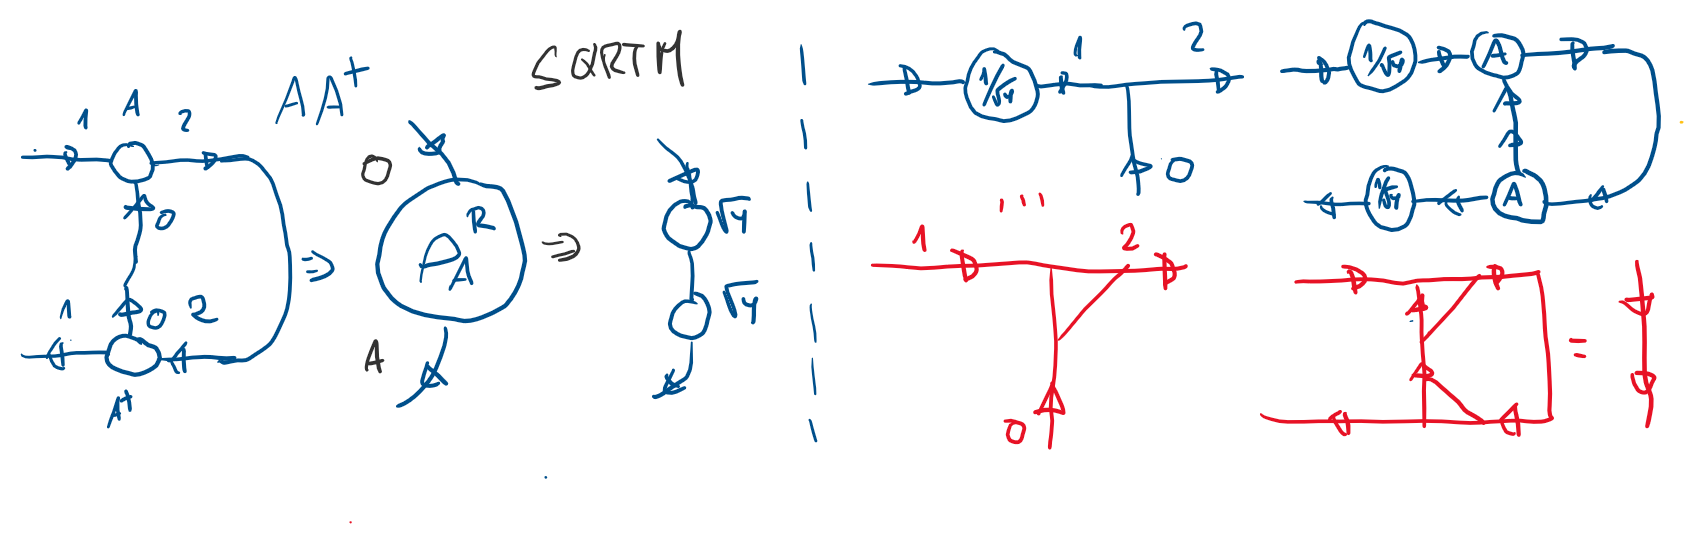

In [ ]:
def right_isometry_do(tensor):
    """
    Computes right isometry using direct orthogonalization
    """
    # Computes Right density matrix
    right_rho = tn.contract_indices(tensor, tensor.conj(), [0, 2],[0, 2])
    sqrt_left = sqrtm(right_rho)
    right_isometry = tn.contract_indices(inv(sqrt_left), tensor, [1], [1])
    right_isometry = right_isometry.transpose(1, 0, 2)
    return right_isometry, sqrt_left

In [ ]:
# Right Isometry Test
right_isometry, sqrt_left = right_isometry_do(tensor)
# Left Isometry Test
np.isclose(
    tn.contract_indices(right_isometry, right_isometry.conj(), [0, 2], [0, 2]),
    np.eye(D)
).all()

In [ ]:
left_isometry, sqrt_right = left_isometry_do(MPS_Zalo[1])
right_isometry, sqrt_left = right_isometry_do(MPS_Zalo[2])

In [ ]:
u, s, v= svd(sqrt_right @ sqrt_left, full_matrices=False)
left_isometry = tn.contract_indices(left_isometry, u, [2], [1])
right_isometry = tn.contract_indices(v, right_isometry, [1], [1])
right_isometry = right_isometry.transpose(1, 0, 2)

In [ ]:
np.isclose(
    tn.contract_indices(left_isometry.conj(), left_isometry, [0, 1], [0, 1]),
    np.eye(D)
).all()

In [ ]:
np.isclose(
    tn.contract_indices(right_isometry, right_isometry.conj(), [0, 2], [0, 2]),
    np.eye(D)
).all()